In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import os
import lmfit
from scipy import special
import function as func
import fit_script as fit


In [4]:
if __name__ == "__main__":
    
    check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])
    
    #start_freq = 26.4
    #print(start_freq)
    #initial = int(start_freq * 1.e+6 - 250)
    #final = int(initial + 1.e+5)
    
    for i in check_freq:
        word = list(str(i*1000 - 250))
        word.insert(2, ".")
        start = "".join(word)
        print(f'start = {start}')
        
        start_freq = (i//100)*100 # MHz
        start_freq *= 1e-3 # GHz
        start_freq = round(start_freq, 6)
        print(f'start_freq = {start_freq}')

        signal = func.csv_to_array("/data/ms2840a/result_data/check_result/signal_12_data/start_{}GHz.csv".format(start))
        W1 = (signal["W_0"] + signal["W_1"] + signal["W_2"] + signal["W_3"] + signal["W_4"] + signal["W_5"] + signal["W_6"] + signal["W_7"] + signal["W_8"] + signal["W_9"] + signal["W_10"] + signal["W_11"])/12 

        signal = func.csv_to_array("/data/ms2840a/result_data/signal_12_data/start_{}GHz.csv".format(start))
        W2 = (signal["W_0"] + signal["W_1"] + signal["W_2"] + signal["W_3"] + signal["W_4"] + signal["W_5"] + signal["W_6"] + signal["W_7"] + signal["W_8"] + signal["W_9"] + signal["W_10"] + signal["W_11"])/12 

        
        # W1 is averaged 10 times more than W2 (W1 measurement time is 10 times more than W2.)
        freq, W, W_err = func.rebin_func(signal["freq"], (W1+W2/10)/1.1) 
        # Save to csv file
        column = ['freq', 'W', 'W_err']
        with open("/data/ms2840a/result_data/check_result/signal_mean_W/start_{}GHz.csv".format(start), "w") as f:
            writer = csv.writer(f)
            writer.writerow(column)
            for j in range(len(freq)):
                writer.writerow([freq[j], W[j], W_err[j]])
                pass
            pass

        # path for fit result on W1(additional measurement)+W2
        path = "/data/ms2840a/result_data/check_result/fit_result_mean_W_test/start_{}GHz.csv".format(start)

        fit.fitting(path, start, start_freq, freq, W)
        pass

start = 18.189750
start_freq = 18.1
start_col = 90000000.0
start = 18.335750
start_freq = 18.3
start_col = 36000000.0
start = 19.119750
start_freq = 19.1
start_col = 20000000.0
start = 19.185750
start_freq = 19.1
start_col = 86000000.0
start = 19.439750
start_freq = 19.4
start_col = 40000000.0
start = 19.477750
start_freq = 19.4
start_col = 78000000.0
start = 19.765750
start_freq = 19.7
start_col = 66000000.0
start = 19.793750
start_freq = 19.7
start_col = 94000000.0
start = 19.817750
start_freq = 19.8
start_col = 18000000.0
start = 20.005750
start_freq = 20.0
start_col = 6000000.0
start = 20.295750
start_freq = 20.2
start_col = 96000000.0
start = 20.301750
start_freq = 20.3
start_col = 2000000.0
start = 20.489750
start_freq = 20.4
start_col = 90000000.0
start = 20.539750
start_freq = 20.5
start_col = 40000000.0
start = 20.891750
start_freq = 20.8
start_col = 92000000.0
start = 21.441750
start_freq = 21.4
start_col = 42000000.0
start = 21.807750
start_freq = 21.8
start_col = 8000000.0


# Fit with a specific frequency span (2MHz)

In [2]:
# Fit with a rebinned Pin
# rebinned here before fit
#input_dir = '/data/ms2840a/result_data'
#outdir = './plot/result_figure/fit_result'
#outdatadir = './output/result_data/fit_result_newrebin'
#rebinfunc = 1 # rebin here

# Fit with a rebinned raw data (rebinfunc=0)
# rebinned at raw data in get_original_signal
#input_dir = './output/result_data_newrebin'
#outdir = './plot/result_figure_newrebin/fit_result'
#outdatadir = './output/result_data_newrebin/fit_result'
#rebinfunc = 2 # No rebin

# Fit with a rebinned (rebinfunc=1) raw data
# rebinned at raw data in get_original_signal
input_dir = './output/result_data_newrebin1'
outdir = './plot/result_figure_newrebin1/fit_result'
outdatadir = './output/result_data_newrebin1/fit_result'
rebinfunc = 2 # No rebin


if not os.path.isdir(outdir):
    os.makedirs(outdir)
    pass
if not os.path.isdir(outdatadir):
    os.makedirs(outdatadir)
    pass

### New rebinning method
$$
p'_n = \sum_{i_n<=i<=f_n} \left( p_i w_i \right) \times \frac{ 2\,\mathrm{kHz} }{ \left( \sum_{i_n<=i<=f_n} {w_i} \right) \mathrm{RBW}}
$$
 - $p'_n$ が rebin 後の n 番目のパワー [W/2kHz] で、$p_i$ が rebin 前のパワー [W/300Hz] (RBW=300 Hz)。
 - n 番目の frequency 内に $i_n$ ~ $f_n$ 番目の $p_i$ が含まれる(少しでもかぶっていたらOK)
 - $w_i$ は $p_i$ が rebin 後の $p'_i$ に影響する weight で、0番目と最後以外は $1$。
     - 0番目は RBW のすべてが 2kHz のビン幅に含まれないので、$w_{i_n} = \frac{f_{up,\,i_n} - f'_{low,\,n}}{300,\mathrm{Hz}}$。
     - 同様に最後のビンに関しても, $w_{f_n} = \frac{f'_{up,\,n} - f_{low,\,f_n}}{300\,\mathrm{Hz}}$ となる
         - $f_{up/low,\,i}$ は rebin 前の i番目のデータの RBW の upper/lower edge
         - $f'_{up/low,\,n}$ は rebin 後の n番目のデータのビンの uppper/lower edge


In [3]:
# freq0: Hz 
def fit_one(freq0, dfreq_0=0, rebinfunc=0, outdir='', outfile='', verbose=1,
           input_dir="/data/ms2840a/result_data"
           ):
    '''
        outdir = '' or outfile = '' # No save
    '''
    if outdir == '' or outfile == '':
        path = ''
    else:
        path = f'{outdir}/{outfile}'
        path_add = f'{outdir}/before_add/{outfile}'
        if not os.path.isdir(outdir+'/before_add'):
            os.makedirs(path_add+'/before_add')
        pass
    
    print(f'*** Fit at frequency = {freq0*1.e-9} GHz ***')
    n_data = 12 # number of measurements
    data_time = 2. # [sec] time for nominal data
    data_time2 = 20. # [sec] time for additional data
    freq0_MHz = freq0*1e-6
    
    # additional data [MHz]
    check_freq = np.array(
        [18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 
         20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 
         23808, 23934, 25328, 25352, 25860, 26274, 26346])
    
    is_add_data = False
    for _check_freq in check_freq:
        # Check if freq0 is in 2MHz measured data span in additional datas
        if _check_freq <= freq0_MHz and freq0_MHz < _check_freq + 2.:
            is_add_data = True
            pass
        pass
    if verbose>0: print('This frequency has an additional data? -->', is_add_data)
    
    
    # Get start freq of 100MHz span
    start_100MHz = (freq0_MHz//100)*100 # MHz (100MHz 毎にする)
    start_100MHz *= 1e-3 # GHz
    start_100MHz = round(start_100MHz, 6) # GHz で小数点以下6桁(kHz)までにする
    if verbose>0: print(f'start_100MHz = {start_100MHz} GHz')
    
    # Get start freq of 2MHz span
    start_2MHz = (freq0_MHz//2)*2 # MHz (2MHz 毎にする)
    start_2MHz *= 1e-3 # GHz
    start_2MHz = round(start_2MHz, 6) # GHz で小数点以下6桁(kHz)までにする
    if verbose>0: print(f'start_2MHz = {start_2MHz} GHz')
    
    # Get start freq of data span (start_2MHz - 0.25 MHz)
    start = start_2MHz - 0.00025
    start = round(start, 6) # GHz で小数点以下6桁(kHz)までにする
    start_str = f'{start:.06f}'
    if verbose>0: print(f'start_str = {start_str}')

    signal = func.csv_to_array(f"{input_dir}/signal_12_data/start_{start_str}GHz.csv")
    freq = signal['freq']
    keys_W = [ f'W_{i}' for i in range(n_data) ]
    W_array = np.array([ signal[key] for key in keys_W ])
    W = np.average(W_array, axis=0) # mean of (W_0, W_1,... W_{n_data})
    if verbose > 0:
        print(f'data keys = {signal.keys()}')
        print(f'power keys = {keys_W}')
        print(f'freq (size={len(freq)}) = ',freq)
        print(f'W (nominal data, size={len(W)}) = ',W)
        pass

    # Add the additional data
    W_add = W
    if is_add_data:
        signal2 = func.csv_to_array(f"{input_dir}/check_result/signal_12_data/start_{start_str}GHz.csv")
        freq2 = signal2['freq']
        W2_array = np.array([ signal2[key] for key in keys_W ])
        W2 = np.average(W2_array, axis=0) # mean of (W_0, W_1,... W_{n_data})
        if verbose > 0: print(f'additional data keys = {signal.keys()}')
        print('W2 (additional data) = ', W2)
        
        # W2 is averaged 10 times more than W (W2 measurement time is 10 times more than W.)
        W_add = (W*data_time+W2*data_time2)/(data_time+data_time2)
        pass
    
    # Rebinning to 2kHz bins
    if   rebinfunc == 0: freq_rebin, W_rebin, W_rebin_err = func.rebin_func(freq, W_add)
    elif rebinfunc == 1: freq_rebin, W_rebin = func.rebin_func_consider_rbw(freq, W_add)
    else               : freq_rebin, W_rebin = freq, W_add
    if verbose > 0:
        print(f'freq_rebin (size:{len(freq_rebin)} = {freq_rebin}')
        print(f'W_rebin (size:{len(W_rebin)} = {W_rebin}')
        pass
    
    result_list = fit.fitting(path, start=start, start_freq=start_100MHz, freq=freq_rebin, signal=W_rebin, dfreq_0=dfreq_0)
    # fit without additional data for add_data
    if is_add_data:
        if   rebinfunc == 0: freq_rebin2, W_rebin2, W_rebin2_err = func.rebin_func(freq, W)
        elif rebinfunc == 1: freq_rebin2, W_rebin2 = func.rebin_func_consider_rbw(freq, W)
        else               : freq_rebin2, W_rebin2 = freq, W
        fit.fitting(path_add, start=start, start_freq=start_100MHz, freq=freq_rebin2, signal=W_rebin2, dfreq_0=dfreq_0)
        pass
        
    freq_0 = np.array(result_list['freq_0'])
    if verbose > 0:
        print(f'result keys = {result_list.keys()}')
        print(f'result freq_0 size:{len(freq_0)}')
        pass
    
    return result_list

# Loop over all frequencies: 18--26.5 GHz (take a time)

In [4]:
# start frequencies with 100MHz steps
for i in range(180, 265, 1):
    if i%10 == 0: print(f'freq = {i*0.1} GHz')
    start_freq = i/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)
    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)
        start_Hz = (float)(start)*1e+9
        #print(start, start_Hz)
        outdir = f'{outdatadir}'
        outfile = f'start_{start}GHz.csv'
        fit_one(start_Hz+1e+6, rebinfunc=rebinfunc, outdir=outdir, outfile=outfile, verbose=0, input_dir=input_dir)
        pass
    pass

freq = 18.0 GHz
*** Fit at frequency = 18.00075 GHz ***
*** Fit at frequency = 18.002750000000002 GHz ***
*** Fit at frequency = 18.00475 GHz ***
*** Fit at frequency = 18.00675 GHz ***
*** Fit at frequency = 18.008750000000003 GHz ***
*** Fit at frequency = 18.01075 GHz ***
*** Fit at frequency = 18.01275 GHz ***
*** Fit at frequency = 18.01475 GHz ***
*** Fit at frequency = 18.016750000000002 GHz ***
*** Fit at frequency = 18.01875 GHz ***
*** Fit at frequency = 18.02075 GHz ***
*** Fit at frequency = 18.022750000000002 GHz ***
*** Fit at frequency = 18.02475 GHz ***
*** Fit at frequency = 18.02675 GHz ***
*** Fit at frequency = 18.028750000000002 GHz ***
*** Fit at frequency = 18.03075 GHz ***
*** Fit at frequency = 18.03275 GHz ***
*** Fit at frequency = 18.034750000000003 GHz ***
*** Fit at frequency = 18.03675 GHz ***
*** Fit at frequency = 18.03875 GHz ***
*** Fit at frequency = 18.040750000000003 GHz ***
*** Fit at frequency = 18.04275 GHz ***
*** Fit at frequency = 18.04475 GH

*** Fit at frequency = 18.368750000000002 GHz ***
*** Fit at frequency = 18.37075 GHz ***
*** Fit at frequency = 18.37275 GHz ***
*** Fit at frequency = 18.374750000000002 GHz ***
*** Fit at frequency = 18.37675 GHz ***
*** Fit at frequency = 18.37875 GHz ***
*** Fit at frequency = 18.380750000000003 GHz ***
*** Fit at frequency = 18.38275 GHz ***
*** Fit at frequency = 18.38475 GHz ***
*** Fit at frequency = 18.386750000000003 GHz ***
*** Fit at frequency = 18.38875 GHz ***
*** Fit at frequency = 18.39075 GHz ***
*** Fit at frequency = 18.39275 GHz ***
*** Fit at frequency = 18.394750000000002 GHz ***
*** Fit at frequency = 18.39675 GHz ***
*** Fit at frequency = 18.39875 GHz ***
*** Fit at frequency = 18.400750000000002 GHz ***
*** Fit at frequency = 18.40275 GHz ***
*** Fit at frequency = 18.40475 GHz ***
*** Fit at frequency = 18.406750000000002 GHz ***
*** Fit at frequency = 18.40875 GHz ***
*** Fit at frequency = 18.41075 GHz ***
*** Fit at frequency = 18.412750000000003 GHz ***


*** Fit at frequency = 18.74875 GHz ***
*** Fit at frequency = 18.75075 GHz ***
*** Fit at frequency = 18.752750000000002 GHz ***
*** Fit at frequency = 18.75475 GHz ***
*** Fit at frequency = 18.75675 GHz ***
*** Fit at frequency = 18.758750000000003 GHz ***
*** Fit at frequency = 18.76075 GHz ***
*** Fit at frequency = 18.76275 GHz ***
*** Fit at frequency = 18.764750000000003 GHz ***
*** Fit at frequency = 18.766750000000002 GHz ***
*** Fit at frequency = 18.76875 GHz ***
*** Fit at frequency = 18.77075 GHz ***
*** Fit at frequency = 18.772750000000002 GHz ***
*** Fit at frequency = 18.77475 GHz ***
*** Fit at frequency = 18.77675 GHz ***
*** Fit at frequency = 18.778750000000002 GHz ***
*** Fit at frequency = 18.78075 GHz ***
*** Fit at frequency = 18.78275 GHz ***
*** Fit at frequency = 18.784750000000003 GHz ***
*** Fit at frequency = 18.78675 GHz ***
*** Fit at frequency = 18.78875 GHz ***
*** Fit at frequency = 18.790750000000003 GHz ***
*** Fit at frequency = 18.79275 GHz ***


*** Fit at frequency = 19.12275 GHz ***
*** Fit at frequency = 19.124750000000002 GHz ***
*** Fit at frequency = 19.12675 GHz ***
*** Fit at frequency = 19.12875 GHz ***
*** Fit at frequency = 19.130750000000003 GHz ***
*** Fit at frequency = 19.13275 GHz ***
*** Fit at frequency = 19.13475 GHz ***
*** Fit at frequency = 19.136750000000003 GHz ***
*** Fit at frequency = 19.13875 GHz ***
*** Fit at frequency = 19.14075 GHz ***
*** Fit at frequency = 19.14275 GHz ***
*** Fit at frequency = 19.144750000000002 GHz ***
*** Fit at frequency = 19.14675 GHz ***
*** Fit at frequency = 19.14875 GHz ***
*** Fit at frequency = 19.150750000000002 GHz ***
*** Fit at frequency = 19.15275 GHz ***
*** Fit at frequency = 19.15475 GHz ***
*** Fit at frequency = 19.156750000000002 GHz ***
*** Fit at frequency = 19.15875 GHz ***
*** Fit at frequency = 19.16075 GHz ***
*** Fit at frequency = 19.162750000000003 GHz ***
*** Fit at frequency = 19.16475 GHz ***
*** Fit at frequency = 19.16675 GHz ***
*** Fit at

*** Fit at frequency = 19.484750000000002 GHz ***
*** Fit at frequency = 19.48675 GHz ***
*** Fit at frequency = 19.48875 GHz ***
*** Fit at frequency = 19.490750000000002 GHz ***
*** Fit at frequency = 19.49275 GHz ***
*** Fit at frequency = 19.49475 GHz ***
*** Fit at frequency = 19.496750000000002 GHz ***
*** Fit at frequency = 19.49875 GHz ***
*** Fit at frequency = 19.50075 GHz ***
*** Fit at frequency = 19.502750000000002 GHz ***
*** Fit at frequency = 19.50475 GHz ***
*** Fit at frequency = 19.50675 GHz ***
*** Fit at frequency = 19.508750000000003 GHz ***
*** Fit at frequency = 19.51075 GHz ***
*** Fit at frequency = 19.51275 GHz ***
*** Fit at frequency = 19.514750000000003 GHz ***
*** Fit at frequency = 19.516750000000002 GHz ***
*** Fit at frequency = 19.51875 GHz ***
*** Fit at frequency = 19.52075 GHz ***
*** Fit at frequency = 19.522750000000002 GHz ***
*** Fit at frequency = 19.52475 GHz ***
*** Fit at frequency = 19.52675 GHz ***
*** Fit at frequency = 19.52875000000000

*** Fit at frequency = 19.84475 GHz ***
*** Fit at frequency = 19.84675 GHz ***
*** Fit at frequency = 19.848750000000003 GHz ***
*** Fit at frequency = 19.85075 GHz ***
*** Fit at frequency = 19.85275 GHz ***
*** Fit at frequency = 19.854750000000003 GHz ***
*** Fit at frequency = 19.85675 GHz ***
*** Fit at frequency = 19.85875 GHz ***
*** Fit at frequency = 19.860750000000003 GHz ***
*** Fit at frequency = 19.862750000000002 GHz ***
*** Fit at frequency = 19.86475 GHz ***
*** Fit at frequency = 19.86675 GHz ***
*** Fit at frequency = 19.868750000000002 GHz ***
*** Fit at frequency = 19.87075 GHz ***
*** Fit at frequency = 19.87275 GHz ***
*** Fit at frequency = 19.874750000000002 GHz ***
*** Fit at frequency = 19.87675 GHz ***
*** Fit at frequency = 19.87875 GHz ***
*** Fit at frequency = 19.880750000000003 GHz ***
*** Fit at frequency = 19.88275 GHz ***
*** Fit at frequency = 19.88475 GHz ***
*** Fit at frequency = 19.886750000000003 GHz ***
*** Fit at frequency = 19.88875 GHz ***


*** Fit at frequency = 20.21675 GHz ***
*** Fit at frequency = 20.21875 GHz ***
*** Fit at frequency = 20.220750000000002 GHz ***
*** Fit at frequency = 20.22275 GHz ***
*** Fit at frequency = 20.22475 GHz ***
*** Fit at frequency = 20.226750000000003 GHz ***
*** Fit at frequency = 20.22875 GHz ***
*** Fit at frequency = 20.23075 GHz ***
*** Fit at frequency = 20.232750000000003 GHz ***
*** Fit at frequency = 20.234750000000002 GHz ***
*** Fit at frequency = 20.23675 GHz ***
*** Fit at frequency = 20.23875 GHz ***
*** Fit at frequency = 20.240750000000002 GHz ***
*** Fit at frequency = 20.24275 GHz ***
*** Fit at frequency = 20.24475 GHz ***
*** Fit at frequency = 20.246750000000002 GHz ***
*** Fit at frequency = 20.24875 GHz ***
*** Fit at frequency = 20.25075 GHz ***
*** Fit at frequency = 20.252750000000002 GHz ***
*** Fit at frequency = 20.25475 GHz ***
*** Fit at frequency = 20.25675 GHz ***
*** Fit at frequency = 20.258750000000003 GHz ***
*** Fit at frequency = 20.26075 GHz ***


*** Fit at frequency = 20.57075 GHz ***
*** Fit at frequency = 20.572750000000003 GHz ***
*** Fit at frequency = 20.57475 GHz ***
*** Fit at frequency = 20.57675 GHz ***
*** Fit at frequency = 20.578750000000003 GHz ***
*** Fit at frequency = 20.580750000000002 GHz ***
*** Fit at frequency = 20.58275 GHz ***
*** Fit at frequency = 20.58475 GHz ***
*** Fit at frequency = 20.586750000000002 GHz ***
*** Fit at frequency = 20.58875 GHz ***
*** Fit at frequency = 20.59075 GHz ***
*** Fit at frequency = 20.592750000000002 GHz ***
*** Fit at frequency = 20.59475 GHz ***
*** Fit at frequency = 20.59675 GHz ***
*** Fit at frequency = 20.598750000000003 GHz ***
*** Fit at frequency = 20.60075 GHz ***
*** Fit at frequency = 20.60275 GHz ***
*** Fit at frequency = 20.604750000000003 GHz ***
*** Fit at frequency = 20.60675 GHz ***
*** Fit at frequency = 20.60875 GHz ***
*** Fit at frequency = 20.610750000000003 GHz ***
*** Fit at frequency = 20.612750000000002 GHz ***
*** Fit at frequency = 20.6147

*** Fit at frequency = 20.94075 GHz ***
*** Fit at frequency = 20.94275 GHz ***
*** Fit at frequency = 20.944750000000003 GHz ***
*** Fit at frequency = 20.94675 GHz ***
*** Fit at frequency = 20.94875 GHz ***
*** Fit at frequency = 20.950750000000003 GHz ***
*** Fit at frequency = 20.95275 GHz ***
*** Fit at frequency = 20.95475 GHz ***
*** Fit at frequency = 20.95675 GHz ***
*** Fit at frequency = 20.958750000000002 GHz ***
*** Fit at frequency = 20.96075 GHz ***
*** Fit at frequency = 20.96275 GHz ***
*** Fit at frequency = 20.964750000000002 GHz ***
*** Fit at frequency = 20.96675 GHz ***
*** Fit at frequency = 20.96875 GHz ***
*** Fit at frequency = 20.970750000000002 GHz ***
*** Fit at frequency = 20.97275 GHz ***
*** Fit at frequency = 20.97475 GHz ***
*** Fit at frequency = 20.976750000000003 GHz ***
*** Fit at frequency = 20.97875 GHz ***
*** Fit at frequency = 20.98075 GHz ***
*** Fit at frequency = 20.982750000000003 GHz ***
*** Fit at frequency = 20.984750000000002 GHz ***


*** Fit at frequency = 21.316750000000003 GHz ***
*** Fit at frequency = 21.31875 GHz ***
*** Fit at frequency = 21.32075 GHz ***
*** Fit at frequency = 21.322750000000003 GHz ***
*** Fit at frequency = 21.32475 GHz ***
*** Fit at frequency = 21.32675 GHz ***
*** Fit at frequency = 21.328750000000003 GHz ***
*** Fit at frequency = 21.330750000000002 GHz ***
*** Fit at frequency = 21.33275 GHz ***
*** Fit at frequency = 21.33475 GHz ***
*** Fit at frequency = 21.336750000000002 GHz ***
*** Fit at frequency = 21.33875 GHz ***
*** Fit at frequency = 21.34075 GHz ***
*** Fit at frequency = 21.342750000000002 GHz ***
*** Fit at frequency = 21.34475 GHz ***
*** Fit at frequency = 21.34675 GHz ***
*** Fit at frequency = 21.348750000000003 GHz ***
*** Fit at frequency = 21.35075 GHz ***
*** Fit at frequency = 21.35275 GHz ***
*** Fit at frequency = 21.354750000000003 GHz ***
*** Fit at frequency = 21.35675 GHz ***
*** Fit at frequency = 21.35875 GHz ***
*** Fit at frequency = 21.36075000000000

*** Fit at frequency = 21.68675 GHz ***
*** Fit at frequency = 21.688750000000002 GHz ***
*** Fit at frequency = 21.69075 GHz ***
*** Fit at frequency = 21.69275 GHz ***
*** Fit at frequency = 21.694750000000003 GHz ***
*** Fit at frequency = 21.69675 GHz ***
*** Fit at frequency = 21.69875 GHz ***
*** Fit at frequency = 21.700750000000003 GHz ***
*** Fit at frequency = 21.70275 GHz ***
*** Fit at frequency = 21.70475 GHz ***
*** Fit at frequency = 21.706750000000003 GHz ***
*** Fit at frequency = 21.708750000000002 GHz ***
*** Fit at frequency = 21.71075 GHz ***
*** Fit at frequency = 21.71275 GHz ***
*** Fit at frequency = 21.714750000000002 GHz ***
*** Fit at frequency = 21.71675 GHz ***
*** Fit at frequency = 21.71875 GHz ***
*** Fit at frequency = 21.720750000000002 GHz ***
*** Fit at frequency = 21.72275 GHz ***
*** Fit at frequency = 21.72475 GHz ***
*** Fit at frequency = 21.726750000000003 GHz ***
*** Fit at frequency = 21.72875 GHz ***
*** Fit at frequency = 21.73075 GHz ***


*** Fit at frequency = 22.054750000000002 GHz ***
*** Fit at frequency = 22.05675 GHz ***
*** Fit at frequency = 22.05875 GHz ***
*** Fit at frequency = 22.060750000000002 GHz ***
*** Fit at frequency = 22.06275 GHz ***
*** Fit at frequency = 22.06475 GHz ***
*** Fit at frequency = 22.066750000000003 GHz ***
*** Fit at frequency = 22.06875 GHz ***
*** Fit at frequency = 22.07075 GHz ***
*** Fit at frequency = 22.072750000000003 GHz ***
*** Fit at frequency = 22.07475 GHz ***
*** Fit at frequency = 22.07675 GHz ***
*** Fit at frequency = 22.078750000000003 GHz ***
*** Fit at frequency = 22.080750000000002 GHz ***
*** Fit at frequency = 22.08275 GHz ***
*** Fit at frequency = 22.08475 GHz ***
*** Fit at frequency = 22.086750000000002 GHz ***
*** Fit at frequency = 22.08875 GHz ***
*** Fit at frequency = 22.09075 GHz ***
*** Fit at frequency = 22.092750000000002 GHz ***
*** Fit at frequency = 22.09475 GHz ***
*** Fit at frequency = 22.09675 GHz ***
*** Fit at frequency = 22.09875000000000

*** Fit at frequency = 22.42875 GHz ***
*** Fit at frequency = 22.43075 GHz ***
*** Fit at frequency = 22.432750000000002 GHz ***
*** Fit at frequency = 22.43475 GHz ***
*** Fit at frequency = 22.43675 GHz ***
*** Fit at frequency = 22.438750000000002 GHz ***
*** Fit at frequency = 22.44075 GHz ***
*** Fit at frequency = 22.44275 GHz ***
*** Fit at frequency = 22.444750000000003 GHz ***
*** Fit at frequency = 22.44675 GHz ***
*** Fit at frequency = 22.44875 GHz ***
*** Fit at frequency = 22.450750000000003 GHz ***
*** Fit at frequency = 22.45275 GHz ***
*** Fit at frequency = 22.45475 GHz ***
*** Fit at frequency = 22.456750000000003 GHz ***
*** Fit at frequency = 22.458750000000002 GHz ***
*** Fit at frequency = 22.46075 GHz ***
*** Fit at frequency = 22.46275 GHz ***
*** Fit at frequency = 22.464750000000002 GHz ***
*** Fit at frequency = 22.46675 GHz ***
*** Fit at frequency = 22.46875 GHz ***
*** Fit at frequency = 22.470750000000002 GHz ***
*** Fit at frequency = 22.47275 GHz ***


*** Fit at frequency = 22.79275 GHz ***
*** Fit at frequency = 22.79475 GHz ***
*** Fit at frequency = 22.796750000000003 GHz ***
*** Fit at frequency = 22.798750000000002 GHz ***
*** Fit at frequency = 22.80075 GHz ***
*** Fit at frequency = 22.802750000000003 GHz ***
*** Fit at frequency = 22.804750000000002 GHz ***
*** Fit at frequency = 22.80675 GHz ***
*** Fit at frequency = 22.80875 GHz ***
*** Fit at frequency = 22.810750000000002 GHz ***
*** Fit at frequency = 22.81275 GHz ***
*** Fit at frequency = 22.81475 GHz ***
*** Fit at frequency = 22.816750000000003 GHz ***
*** Fit at frequency = 22.81875 GHz ***
*** Fit at frequency = 22.82075 GHz ***
*** Fit at frequency = 22.822750000000003 GHz ***
*** Fit at frequency = 22.82475 GHz ***
*** Fit at frequency = 22.82675 GHz ***
*** Fit at frequency = 22.828750000000003 GHz ***
*** Fit at frequency = 22.830750000000002 GHz ***
*** Fit at frequency = 22.83275 GHz ***
*** Fit at frequency = 22.83475 GHz ***
*** Fit at frequency = 22.8367

*** Fit at frequency = 23.16475 GHz ***
*** Fit at frequency = 23.16675 GHz ***
*** Fit at frequency = 23.168750000000003 GHz ***
*** Fit at frequency = 23.17075 GHz ***
*** Fit at frequency = 23.17275 GHz ***
*** Fit at frequency = 23.174750000000003 GHz ***
*** Fit at frequency = 23.176750000000002 GHz ***
*** Fit at frequency = 23.17875 GHz ***
*** Fit at frequency = 23.18075 GHz ***
*** Fit at frequency = 23.182750000000002 GHz ***
*** Fit at frequency = 23.18475 GHz ***
*** Fit at frequency = 23.18675 GHz ***
*** Fit at frequency = 23.188750000000002 GHz ***
*** Fit at frequency = 23.19075 GHz ***
*** Fit at frequency = 23.19275 GHz ***
*** Fit at frequency = 23.194750000000003 GHz ***
*** Fit at frequency = 23.19675 GHz ***
*** Fit at frequency = 23.19875 GHz ***
*** Fit at frequency = 23.200750000000003 GHz ***
*** Fit at frequency = 23.20275 GHz ***
*** Fit at frequency = 23.20475 GHz ***
*** Fit at frequency = 23.206750000000003 GHz ***
*** Fit at frequency = 23.20875000000000

*** Fit at frequency = 23.53275 GHz ***
*** Fit at frequency = 23.534750000000003 GHz ***
*** Fit at frequency = 23.53675 GHz ***
*** Fit at frequency = 23.53875 GHz ***
*** Fit at frequency = 23.540750000000003 GHz ***
*** Fit at frequency = 23.54275 GHz ***
*** Fit at frequency = 23.54475 GHz ***
*** Fit at frequency = 23.546750000000003 GHz ***
*** Fit at frequency = 23.548750000000002 GHz ***
*** Fit at frequency = 23.55075 GHz ***
*** Fit at frequency = 23.552750000000003 GHz ***
*** Fit at frequency = 23.554750000000002 GHz ***
*** Fit at frequency = 23.55675 GHz ***
*** Fit at frequency = 23.55875 GHz ***
*** Fit at frequency = 23.560750000000002 GHz ***
*** Fit at frequency = 23.56275 GHz ***
*** Fit at frequency = 23.56475 GHz ***
*** Fit at frequency = 23.566750000000003 GHz ***
*** Fit at frequency = 23.56875 GHz ***
*** Fit at frequency = 23.57075 GHz ***
*** Fit at frequency = 23.572750000000003 GHz ***
*** Fit at frequency = 23.57475 GHz ***
*** Fit at frequency = 23.5767

*** Fit at frequency = 23.89875 GHz ***
*** Fit at frequency = 23.900750000000002 GHz ***
*** Fit at frequency = 23.90275 GHz ***
*** Fit at frequency = 23.90475 GHz ***
*** Fit at frequency = 23.906750000000002 GHz ***
*** Fit at frequency = 23.90875 GHz ***
*** Fit at frequency = 23.91075 GHz ***
*** Fit at frequency = 23.912750000000003 GHz ***
*** Fit at frequency = 23.91475 GHz ***
*** Fit at frequency = 23.91675 GHz ***
*** Fit at frequency = 23.918750000000003 GHz ***
*** Fit at frequency = 23.92075 GHz ***
*** Fit at frequency = 23.92275 GHz ***
*** Fit at frequency = 23.924750000000003 GHz ***
*** Fit at frequency = 23.926750000000002 GHz ***
*** Fit at frequency = 23.92875 GHz ***
*** Fit at frequency = 23.93075 GHz ***
*** Fit at frequency = 23.932750000000002 GHz ***
*** Fit at frequency = 23.93475 GHz ***
W2 (additional data) =  [1.77607412e-18 1.79086980e-18 1.76913835e-18 ... 1.25991219e-18
 1.27788459e-18 1.28304151e-18]
*** Fit at frequency = 23.93675 GHz ***
*** Fit a

*** Fit at frequency = 24.264750000000003 GHz ***
*** Fit at frequency = 24.266750000000002 GHz ***
*** Fit at frequency = 24.26875 GHz ***
*** Fit at frequency = 24.270750000000003 GHz ***
*** Fit at frequency = 24.272750000000002 GHz ***
*** Fit at frequency = 24.27475 GHz ***
*** Fit at frequency = 24.27675 GHz ***
*** Fit at frequency = 24.278750000000002 GHz ***
*** Fit at frequency = 24.28075 GHz ***
*** Fit at frequency = 24.28275 GHz ***
*** Fit at frequency = 24.284750000000003 GHz ***
*** Fit at frequency = 24.28675 GHz ***
*** Fit at frequency = 24.28875 GHz ***
*** Fit at frequency = 24.290750000000003 GHz ***
*** Fit at frequency = 24.29275 GHz ***
*** Fit at frequency = 24.29475 GHz ***
*** Fit at frequency = 24.296750000000003 GHz ***
*** Fit at frequency = 24.298750000000002 GHz ***
*** Fit at frequency = 24.30075 GHz ***
*** Fit at frequency = 24.302750000000003 GHz ***
*** Fit at frequency = 24.304750000000002 GHz ***
*** Fit at frequency = 24.30675 GHz ***
*** Fit at

*** Fit at frequency = 24.63475 GHz ***
*** Fit at frequency = 24.636750000000003 GHz ***
*** Fit at frequency = 24.63875 GHz ***
*** Fit at frequency = 24.64075 GHz ***
*** Fit at frequency = 24.642750000000003 GHz ***
*** Fit at frequency = 24.644750000000002 GHz ***
*** Fit at frequency = 24.64675 GHz ***
*** Fit at frequency = 24.648750000000003 GHz ***
*** Fit at frequency = 24.650750000000002 GHz ***
*** Fit at frequency = 24.65275 GHz ***
*** Fit at frequency = 24.65475 GHz ***
*** Fit at frequency = 24.656750000000002 GHz ***
*** Fit at frequency = 24.65875 GHz ***
*** Fit at frequency = 24.66075 GHz ***
*** Fit at frequency = 24.662750000000003 GHz ***
*** Fit at frequency = 24.66475 GHz ***
*** Fit at frequency = 24.66675 GHz ***
*** Fit at frequency = 24.668750000000003 GHz ***
*** Fit at frequency = 24.67075 GHz ***
*** Fit at frequency = 24.67275 GHz ***
*** Fit at frequency = 24.674750000000003 GHz ***
*** Fit at frequency = 24.676750000000002 GHz ***
*** Fit at frequency

*** Fit at frequency = 25.00475 GHz ***
*** Fit at frequency = 25.00675 GHz ***
*** Fit at frequency = 25.008750000000003 GHz ***
*** Fit at frequency = 25.01075 GHz ***
*** Fit at frequency = 25.01275 GHz ***
*** Fit at frequency = 25.014750000000003 GHz ***
*** Fit at frequency = 25.016750000000002 GHz ***
*** Fit at frequency = 25.01875 GHz ***
*** Fit at frequency = 25.020750000000003 GHz ***
*** Fit at frequency = 25.022750000000002 GHz ***
*** Fit at frequency = 25.02475 GHz ***
*** Fit at frequency = 25.02675 GHz ***
*** Fit at frequency = 25.028750000000002 GHz ***
*** Fit at frequency = 25.03075 GHz ***
*** Fit at frequency = 25.03275 GHz ***
*** Fit at frequency = 25.034750000000003 GHz ***
*** Fit at frequency = 25.03675 GHz ***
*** Fit at frequency = 25.03875 GHz ***
*** Fit at frequency = 25.040750000000003 GHz ***
*** Fit at frequency = 25.04275 GHz ***
*** Fit at frequency = 25.04475 GHz ***
*** Fit at frequency = 25.046750000000003 GHz ***
*** Fit at frequency = 25.0487

*** Fit at frequency = 25.36475 GHz ***
*** Fit at frequency = 25.366750000000003 GHz ***
*** Fit at frequency = 25.368750000000002 GHz ***
*** Fit at frequency = 25.37075 GHz ***
*** Fit at frequency = 25.37275 GHz ***
*** Fit at frequency = 25.374750000000002 GHz ***
*** Fit at frequency = 25.37675 GHz ***
*** Fit at frequency = 25.37875 GHz ***
*** Fit at frequency = 25.380750000000003 GHz ***
*** Fit at frequency = 25.38275 GHz ***
*** Fit at frequency = 25.38475 GHz ***
*** Fit at frequency = 25.386750000000003 GHz ***
*** Fit at frequency = 25.38875 GHz ***
*** Fit at frequency = 25.39075 GHz ***
*** Fit at frequency = 25.392750000000003 GHz ***
*** Fit at frequency = 25.394750000000002 GHz ***
*** Fit at frequency = 25.39675 GHz ***
*** Fit at frequency = 25.398750000000003 GHz ***
*** Fit at frequency = 25.400750000000002 GHz ***
*** Fit at frequency = 25.40275 GHz ***
*** Fit at frequency = 25.40475 GHz ***
*** Fit at frequency = 25.406750000000002 GHz ***
*** Fit at frequency

*** Fit at frequency = 25.734750000000002 GHz ***
*** Fit at frequency = 25.73675 GHz ***
*** Fit at frequency = 25.738750000000003 GHz ***
*** Fit at frequency = 25.740750000000002 GHz ***
*** Fit at frequency = 25.74275 GHz ***
*** Fit at frequency = 25.744750000000003 GHz ***
*** Fit at frequency = 25.746750000000002 GHz ***
*** Fit at frequency = 25.74875 GHz ***
*** Fit at frequency = 25.75075 GHz ***
*** Fit at frequency = 25.752750000000002 GHz ***
*** Fit at frequency = 25.75475 GHz ***
*** Fit at frequency = 25.75675 GHz ***
*** Fit at frequency = 25.758750000000003 GHz ***
*** Fit at frequency = 25.76075 GHz ***
*** Fit at frequency = 25.76275 GHz ***
*** Fit at frequency = 25.764750000000003 GHz ***
*** Fit at frequency = 25.766750000000002 GHz ***
*** Fit at frequency = 25.76875 GHz ***
*** Fit at frequency = 25.770750000000003 GHz ***
*** Fit at frequency = 25.772750000000002 GHz ***
*** Fit at frequency = 25.77475 GHz ***
*** Fit at frequency = 25.77675 GHz ***
*** Fit at

*** Fit at frequency = 26.09675 GHz ***
*** Fit at frequency = 26.098750000000003 GHz ***
*** Fit at frequency = 26.10075 GHz ***
*** Fit at frequency = 26.10275 GHz ***
*** Fit at frequency = 26.104750000000003 GHz ***
*** Fit at frequency = 26.10675 GHz ***
*** Fit at frequency = 26.10875 GHz ***
*** Fit at frequency = 26.110750000000003 GHz ***
*** Fit at frequency = 26.112750000000002 GHz ***
*** Fit at frequency = 26.11475 GHz ***
*** Fit at frequency = 26.116750000000003 GHz ***
*** Fit at frequency = 26.118750000000002 GHz ***
*** Fit at frequency = 26.12075 GHz ***
*** Fit at frequency = 26.12275 GHz ***
*** Fit at frequency = 26.124750000000002 GHz ***
*** Fit at frequency = 26.12675 GHz ***
*** Fit at frequency = 26.12875 GHz ***
*** Fit at frequency = 26.130750000000003 GHz ***
*** Fit at frequency = 26.13275 GHz ***
*** Fit at frequency = 26.13475 GHz ***
*** Fit at frequency = 26.136750000000003 GHz ***
*** Fit at frequency = 26.13875 GHz ***
*** Fit at frequency = 26.1407

*** Fit at frequency = 26.45475 GHz ***
*** Fit at frequency = 26.456750000000003 GHz ***
*** Fit at frequency = 26.458750000000002 GHz ***
*** Fit at frequency = 26.46075 GHz ***
*** Fit at frequency = 26.462750000000003 GHz ***
*** Fit at frequency = 26.464750000000002 GHz ***
*** Fit at frequency = 26.46675 GHz ***
*** Fit at frequency = 26.46875 GHz ***
*** Fit at frequency = 26.470750000000002 GHz ***
*** Fit at frequency = 26.47275 GHz ***
*** Fit at frequency = 26.47475 GHz ***
*** Fit at frequency = 26.476750000000003 GHz ***
*** Fit at frequency = 26.47875 GHz ***
*** Fit at frequency = 26.48075 GHz ***
*** Fit at frequency = 26.482750000000003 GHz ***
*** Fit at frequency = 26.484750000000002 GHz ***
*** Fit at frequency = 26.48675 GHz ***
*** Fit at frequency = 26.488750000000003 GHz ***
*** Fit at frequency = 26.490750000000002 GHz ***
*** Fit at frequency = 26.49275 GHz ***
*** Fit at frequency = 26.494750000000003 GHz ***
*** Fit at frequency = 26.496750000000002 GHz ***


# Check of fit result

##  Compare between old rebinning and new rebinning

In [29]:
# Fit with nominal data
_freq0 = 18e+9
result_list1 = fit_one(_freq0, rebinfunc=0) # (freq1, P1, P_err1)
result_list2 = fit_one(_freq0, rebinfunc=1) # (freq2, P2, P_err2)

*** Fit at frequency = 18.0 GHz ***
This frequency has an additional data? --> False
start_100MHz = 18.0 GHz
start_2MHz = 18.0 GHz
start_str = 17.999750
data keys = dict_keys(['freq', 'W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', 'W_11'])
power keys = ['W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', 'W_11']
freq (size=32769) =  [1.79997500e+10 1.79997501e+10 1.79997502e+10 ... 1.80022498e+10
 1.80022499e+10 1.80022500e+10]
W (nominal data, size=32769) =  [2.58616277e-19 2.47560988e-19 2.37607758e-19 ... 2.69925855e-19
 2.68038792e-19 2.68781925e-19]
freq_rebin (size:1250 = [1.7999751e+10 1.7999753e+10 1.7999755e+10 ... 1.8002245e+10 1.8002247e+10
 1.8002249e+10]
W_rebin (size:1250 = [2.48687512e-19 2.61308141e-19 2.58436164e-19 ... 2.67740541e-19
 2.67986734e-19 2.72952680e-19]
start_col = 0.0
result keys = dict_keys(['a', 'b', 'P', 'a_err', 'b_err', 'P_err', 'freq_0', 'redchi', 'success'])
result freq_0 size:1000
*** Fit at

In [34]:
# Retrieve original fit result (freq0, P0, P_err0)
# Get start frequency in file name
start_str, tmp, is_add_data = func.get_file_freq(_freq0)
if not is_add_data: fit_path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start_str)
else:               fit_path = "/data/ms2840a/result_data/check_data/fit_result/start_{}GHz.csv".format(start_str)
data = func.csv_to_array(fit_path)
_freq0 = data['freq_0']
_P0 = data["P"] 
_P_err0 = data["P_err"] 

freq0: 18000000.0--18001998.0
freq1: 18000000.0--18001998.0
freq2: 18000000.0--18001998.0


Text(0.5, 113.99999999999989, 'Frequency [kHz]')

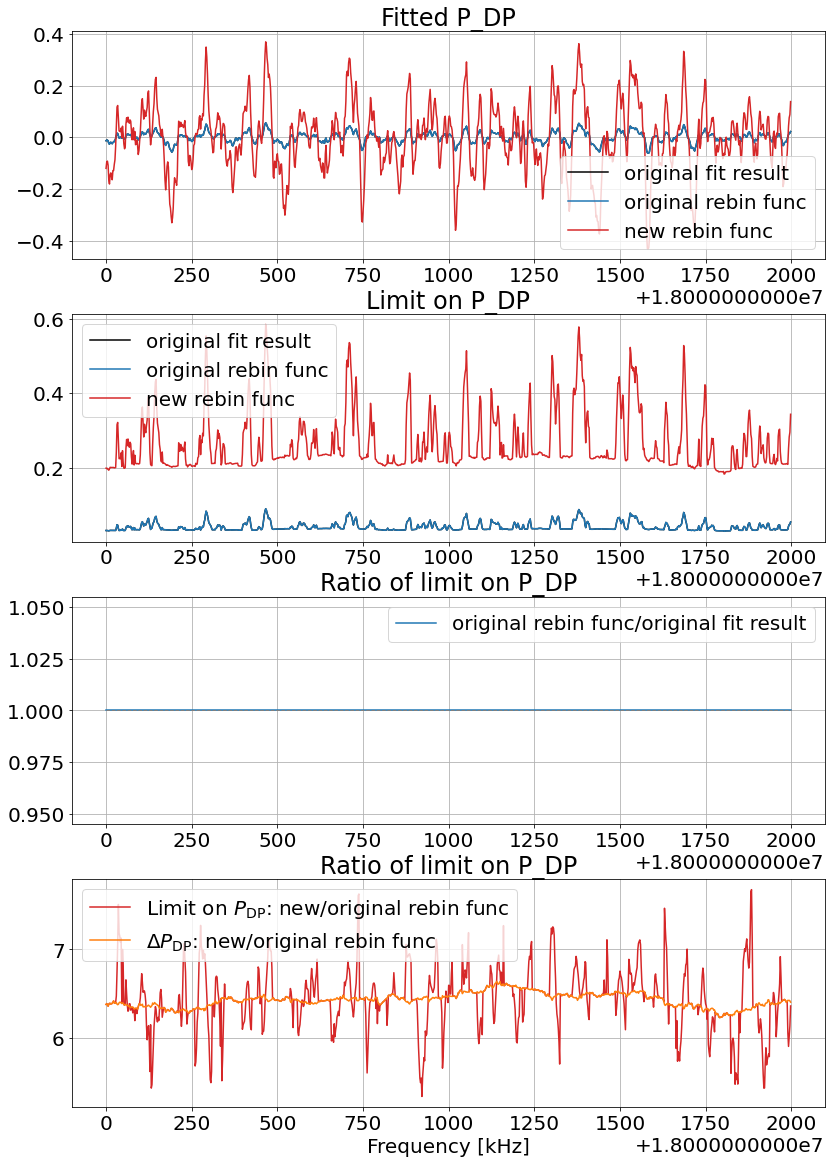

In [41]:
freq0 = np.array(_freq0) * 1e-3 # kHz
freq1 = np.array(result_list1['freq_0']) * 1e-3 # kHz
freq2 = np.array(result_list2['freq_0']) * 1e-3 # kHz
print(f'freq0: {min(freq0)}--{max(freq0)}')
print(f'freq1: {min(freq1)}--{max(freq1)}')
print(f'freq2: {min(freq2)}--{max(freq2)}')

to_aW = 1e+18
P0 = np.array(_P0) * to_aW # aW
P1 = np.array(result_list1['P']) * to_aW # aW
P2 = np.array(result_list2['P']) * to_aW # aW
P_err0 = np.array(_P_err0) * to_aW # aW
P_err1 = np.array(result_list1['P_err']) * to_aW # aW
P_err2 = np.array(result_list2['P_err']) * to_aW # aW

sigma_95CL = 1.715 # Get from get_N_eff.ipynb
zero0 = np.full(len(P0), 0)
zero1 = np.full(len(P1), 0)
zero2 = np.full(len(P2), 0)
limit0 = np.max([P0,zero0], axis=0) + sigma_95CL*P_err0
limit1 = np.max([P1,zero1], axis=0) + sigma_95CL*P_err1
limit2 = np.max([P2,zero2], axis=0) + sigma_95CL*P_err2

plt.rcParams["font.size"] = 20
fig, axes = plt.subplots(4,1,figsize=(12,16), squeeze=False, sharex=False)
fig.tight_layout()

ax=axes[0][0]
ax.plot(freq0, P0, c='black', label='original fit result')
ax.plot(freq1, P1, c='tab:blue', label='original rebin func')
ax.plot(freq2, P2, c='tab:red', label='new rebin func')
ax.set_title('Fitted P_DP')
ax.grid()
ax.legend()

ax=axes[1][0]
ax.plot(freq0, limit0, c='black', label='original fit result')
ax.plot(freq1, limit1, c='tab:blue', label='original rebin func')
ax.plot(freq2, limit2, c='tab:red', label='new rebin func')
ax.set_title('Limit on P_DP')
ax.grid()
ax.legend()

ax=axes[2][0]
ax.plot(freq0, limit1/limit0, c='tab:blue', label='original rebin func/original fit result')
ax.plot([freq0[0], freq0[-1]], [1,1], c='gray', linestyle='--', linewidth=1)
ax.set_title('Ratio of limit on P_DP')
ax.grid()
ax.legend()

ax=axes[3][0]
#ax.plot(freq0, limit1/limit0, c='tab:blue', label='original rebin func/original fit result')
ax.plot(freq1, limit2/limit1, c='tab:red', label='Limit on $P_\mathrm{DP}$: new/original rebin func')
#ax.plot(freq1, P2/P1, c='tab:blue', label='$P_\mathrm{DP}$: new/original rebin func')
ax.plot(freq1, P_err2/P_err1, c='tab:orange', label='$\Delta P_\mathrm{DP}$: new/original rebin func')
ax.set_title('Ratio of limit on P_DP')
ax.grid()
ax.legend()
#ax.set_ylim(0.,10)

ax.set_xlabel('Frequency [kHz]')

# Fit with nominal data + additional data
#result_list = fit_one(18e+9+190533e+3)

## Check fit variation by changing the peak frequency in Data

In [100]:
# Change the peak frequency freq_0
dfreq_0 = 1e+3 # [Hz] peak frequency variation
def get_variation_freq0(freq0=18e+9, verbose=0):
    result_list = fit_one(freq0, dfreq_0=0, verbose=0)
    result_list_up = fit_one(freq0, dfreq_0=dfreq_0, verbose=0)
    result_list_down = fit_one(freq0, dfreq_0=-dfreq_0, verbose=0)
    return result_list, result_list_up, result_list_down

def check_variation_freq0(freq0, result_list, result_list_up, result_list_down):
    freq = np.array(result_list['freq_0'])*1e-3 # kHz
    freq_up = np.array(result_list_up['freq_0'])*1e-3 # kHz
    freq_down = np.array(result_list_down['freq_0'])*1e-3 # kHz
    to_aW = 1e+18
    P = np.array(result_list['P'])*to_aW
    P_err = np.array(result_list['P_err'])*to_aW
    P_up = np.array(result_list_up['P'])*to_aW
    P_down = np.array(result_list_down['P'])*to_aW

    dP = np.std(P)
    diff_up = P_up - P
    diff_down = P_down - P
    std_diff_up = np.std(diff_up)
    std_diff_down = np.std(diff_down)
    std_diff_ave = (std_diff_up + std_diff_down)/2.
    diffratio_up = diff_up/dP
    diffratio_down = diff_down/dP
    print(f'Mean. of diff up   = {np.mean(diff_up):f} aW')
    print(f'Mean. of diff down = {np.mean(diff_down):f} aW')
    print(f'Std.. of diff up   = {std_diff_up:f} aW')
    print(f'Std.. of diff down = {std_diff_down:f} aW')
    print(f'Averaged Std.. of diff = {std_diff_ave:f} aW')
    print(f'Mean. of diffratio up   = {np.mean(diffratio_up)*100.:.3f} %')
    print(f'Mean. of diffratio down = {np.mean(diffratio_down)*100.:.3f} %')
    print(f'Std. of diffratio up   = {np.std(diffratio_up)*100.:.3f} %')
    print(f'Std. of diffratio down = {np.std(diffratio_down)*100.:.3f} %')

    # Frequency Plot
    plt.rcParams["font.size"] = 24
    fig, axes = plt.subplots(3,1,figsize=(20,12), squeeze=False, sharex=False)
    fig.tight_layout()

    ax = axes[0][0]
    ax.scatter(freq, P, s=5, color="black", label="Nominal")
    ax.scatter(freq, P_up, s=5, color="tab:red", label=f"Up (-{dfreq_0*1e-3:.1f} kHz)")
    ax.scatter(freq, P_down, s=5, color="tab:blue", label=f"Down (+{dfreq_0*1e-3:.1f} kHz)")
    ax.set_ylabel(r'$P_\mathrm{DP}$ [aW]')
    ax.set_title(r"$P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()

    ax = axes[1][0]
    ax.scatter(freq, diff_up, s=5, color="tab:red", label="Up")
    ax.scatter(freq, diff_down, s=5, color="tab:blue", label="Down")
    ax.set_ylabel(r'Difference of $P_\mathrm{DP}$ [aW]')
    ax.set_title(r"Difference of $P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()
    
    ax = axes[2][0]
    #ax.scatter(freq, diffratio_up, s=5, color="tab:red", label="Up")
    #ax.scatter(freq, diffratio_down, s=5, color="tab:blue", label="Down")
    #ax.set_ylabel(r'Difference ratio of $P_\mathrm{DP}$ [aW]')
    #ax.set_title(r"Difference ratio of $P_{\rm{DP}}$ [aW]")
    #ax.set_ylim(-1,1)
    #ax.set_yticks([-1.0, -0.5, -0.1, 0, 0.1, 0.5, 1.0])
    ax.scatter(freq, P_err, s=5, color="tab:blue", label="$\Delta P_\mathrm{DP}$")
    ax.set_ylabel(r'$\Delta P_\mathrm{DP}$ [aW]')
    ax.set_title(r"$\Delta P_\mathrm{DP}$ [aW]")
    ax.legend()
    ax.grid()

    ax.set_xlabel(r"Frequency [kHz]")
                  
    fig.subplots_adjust(hspace=0.4, left=0.10, right=0.95, bottom=0.0, top=0.95)

    save_file = f"{outdir}/check_freq0_variation_{freq0*1e-9}GHz.pdf"
    fig.savefig(save_file)
    
    # Histogram Plot
    plt.rcParams["font.size"] = 24
    fig, axes = plt.subplots(1,3,figsize=(20,6), squeeze=False, sharex=False)
    fig.tight_layout()

    ax = axes[0][0]
    nbin=50
    ax.hist(P,  bins=nbin, label="Nominal", histtype='step')
    ax.hist(P_up,  bins=nbin, label=f"Up (-{dfreq_0*1e-3:.1f} kHz)", histtype='step')
    ax.hist(P_down,  bins=nbin, label=f"Down (+{dfreq_0*1e-3:.1f} kHz)", histtype='step')
    ax.set_xlabel(r'$P_\mathrm{DP}$ [aW]')
    ax.set_title(r"$P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()

    ax = axes[0][1]
    ax.hist(diff_up,  bins=nbin, label=f"Up", histtype='step')
    ax.hist(diff_down,  bins=nbin, label=f"Down", histtype='step')
    ax.set_xlabel(r'Difference of $P_\mathrm{DP}$ [aW]')
    ax.set_title(r"Difference of $P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()
    
    '''
    ax = axes[0][2]
    ax.hist(diffratio_up,  bins=nbin, label=f"Up", histtype='step')
    ax.hist(diffratio_down,  bins=nbin, label=f"Down", histtype='step')
    ax.set_xlabel(r'Difference ratio of $P_\mathrm{DP}$ [aW]')
    ax.set_title(r"Difference ratio of $P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()
    '''
                  
    fig.subplots_adjust(hspace=0.4, left=0.10, right=0.95, bottom=0.0, top=0.95)

    save_file = f"{outdir}/check_freq0_variation_hist_{freq0*1e-9}GHz.pdf"
    fig.savefig(save_file)
 
    return std_diff_ave/to_aW # [W]

In [6]:
freq0 = 18e+9
nom, up, down = get_variation_freq0(freq0=freq0, verbose=0)

*** Fit at frequency = 18.0 GHz ***
This frequency has an additional data? --> False
start_100MHz = 18.0 GHz
start_2MHz = 18.0 GHz
start_str = 17.999750
start_col = 0.0
*** Fit at frequency = 18.0 GHz ***
This frequency has an additional data? --> False
start_100MHz = 18.0 GHz
start_2MHz = 18.0 GHz
start_str = 17.999750
start_col = 0.0
*** Fit at frequency = 18.0 GHz ***
This frequency has an additional data? --> False
start_100MHz = 18.0 GHz
start_2MHz = 18.0 GHz
start_str = 17.999750
start_col = 0.0


Mean. of diff up   = 0.000083 aW
Mean. of diff down = 0.000040 aW
Std.. of diff up   = 0.003852 aW
Std.. of diff down = 0.003278 aW
Averaged Std.. of diff = 0.003565 aW
Mean. of diffratio up   = 0.418 %
Mean. of diffratio down = 0.202 %
Std. of diffratio up   = 19.479 %
Std. of diffratio down = 16.576 %
Error of P_DP = 3.565079804500539e-21 aW at 17999999991.0 GHz


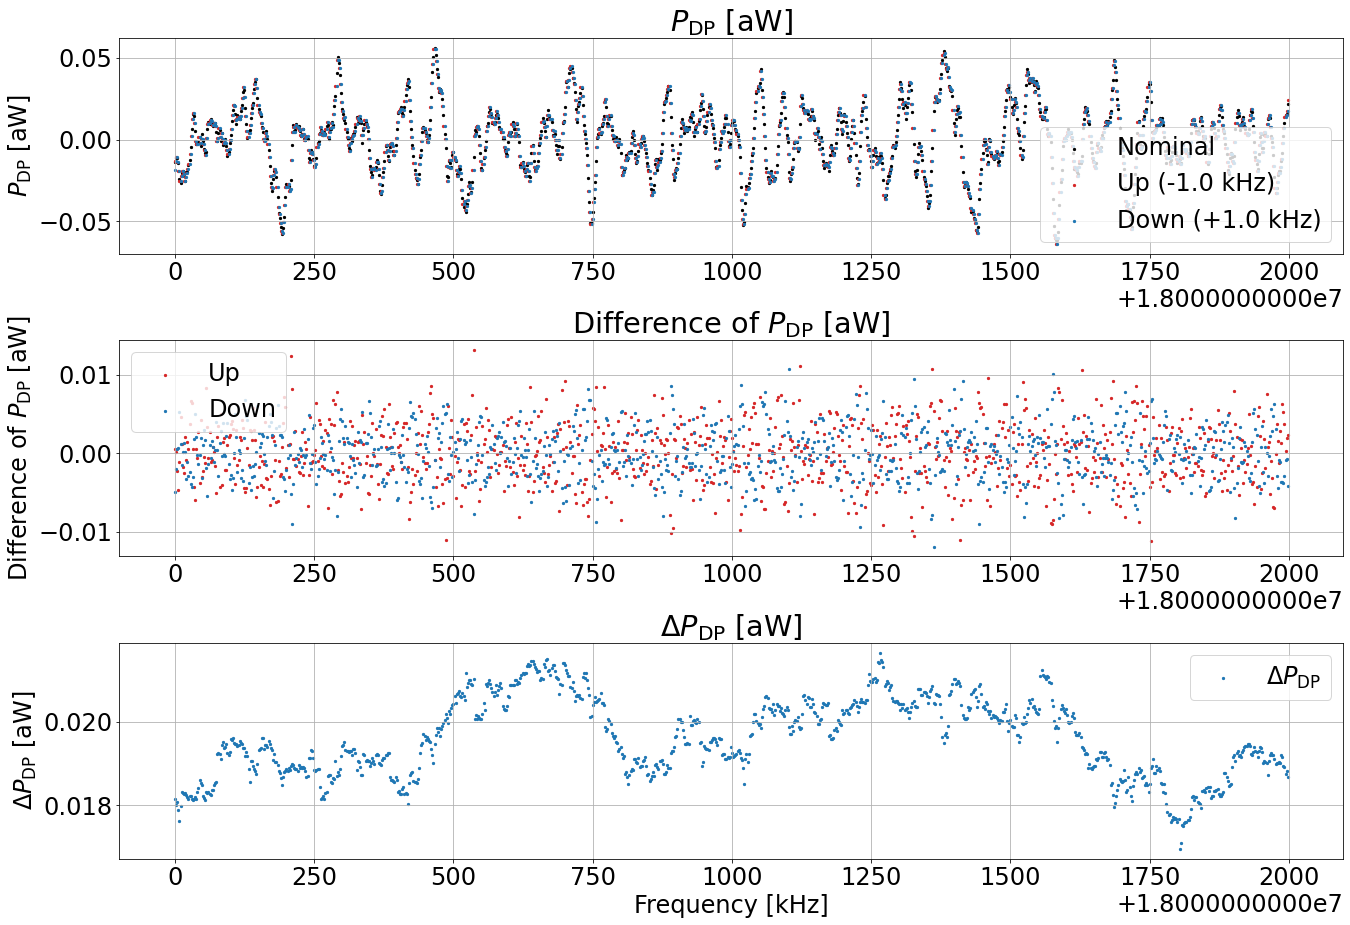

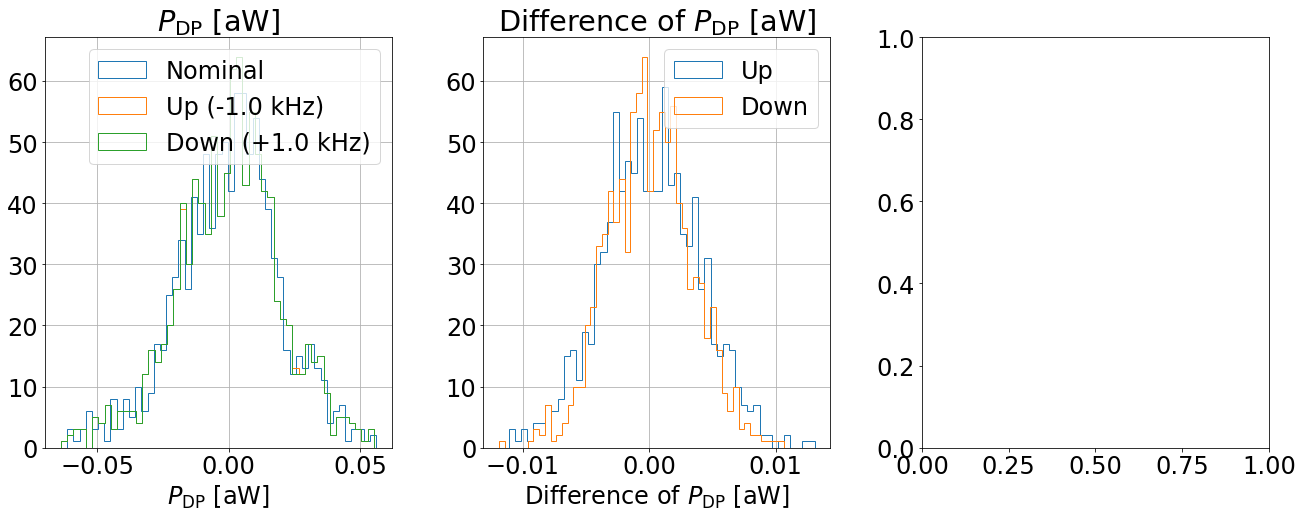

In [101]:
err_P_DP = check_variation_freq0(freq0, nom, up, down)
print(f'Error of P_DP = {err_P_DP} aW at {freq0*1-9} GHz')

In [13]:
freq2 = 26.5e+9-2.e+6
nom2, up2, down2 = get_variation_freq0(freq0=freq2, verbose=0)

*** Fit at frequency = 26.498 GHz ***
This frequency has an additional data? --> False
start_100MHz = 26.4 GHz
start_2MHz = 26.498 GHz
start_str = 26.497750
start_col = 98000000.0
*** Fit at frequency = 26.498 GHz ***
This frequency has an additional data? --> False
start_100MHz = 26.4 GHz
start_2MHz = 26.498 GHz
start_str = 26.497750
start_col = 98000000.0
*** Fit at frequency = 26.498 GHz ***
This frequency has an additional data? --> False
start_100MHz = 26.4 GHz
start_2MHz = 26.498 GHz
start_str = 26.497750
start_col = 98000000.0


Mean. of diff up   = 0.000080 aW
Mean. of diff down = 0.000068 aW
Std.. of diff up   = 0.004389 aW
Std.. of diff down = 0.003866 aW
Averaged Std.. of diff = 0.004128 aW
Mean. of diffratio up   = 0.299 %
Mean. of diffratio down = 0.254 %
Std. of diffratio up   = 16.300 %
Std. of diffratio down = 14.358 %
Error of P_DP = 4.1276142503614574e-21 aW at 26497999991.0 GHz


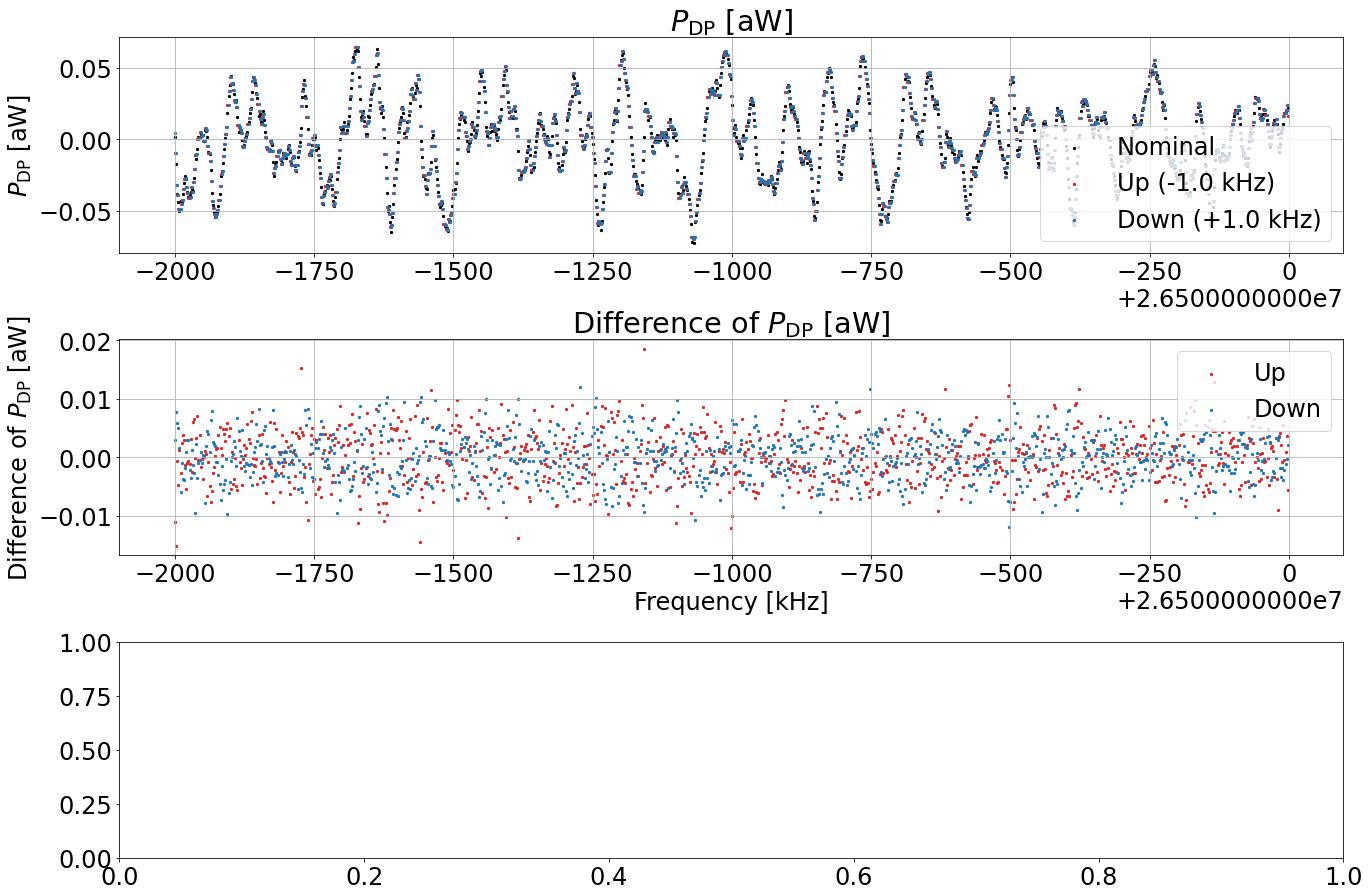

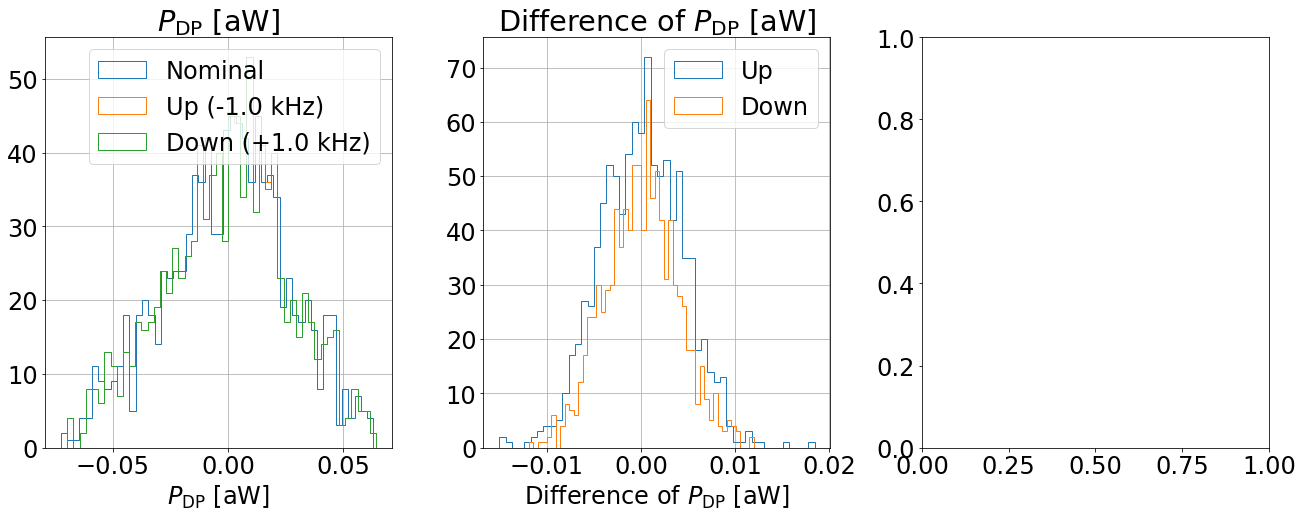

In [17]:
err_P_DP2 = check_variation_freq0(freq2, nom2, up2, down2)
print(f'Error of P_DP = {err_P_DP2} aW at {freq2*1-9} GHz')

In [19]:
print(f'Max. error of P_DP = {max([err_P_DP, err_P_DP2])} W')

Max. error of P_DP = 4.1276142503614574e-21 W


# Check fit variation by changing the peak frequency in simulation
**This will be used for systematic error of binning effect**

In [93]:
fit_before_span = 50.e+3
fit_after_span = 150.e+3
bin_width = 2.e+3

def get_signalsimulation(freq, P, freq_0):
    '''
    freq: frequency array [Hz]
    P: Power of signal [W]
    freq_0: signal peak frequency [Hz]
    '''
    signal = fit.fit_func(freq, a=0, b=0, P=P, freq_0=freq_0)
    return signal

def fit_1point(freq, W, Werr, freq_0):
    params = lmfit.Parameters()
    params.add('a', value=1.)
    params.add('b', value=1.)
    params.add('P', value=1.)
    #print(freq, W, Werr, freq_0)
    result = lmfit.minimize(fit.residual, params, args=(freq, W, Werr, freq_0))
    return result

def fit_on_signal(P, freq_0, dfreq_0=0., verbose=1):
    '''
    P: Power of DP signal [W]
    freq_0: Peak frequency of DP signal [Hz]
    dfreq_0: variation of the peak frequency (fitted freq array will not varied by this.) [Hz]
    '''
    freq = np.arange(freq_0-fit_before_span, freq_0+fit_after_span, bin_width)
    signal = get_signalsimulation(freq, P, freq_0+dfreq_0)
    signal_err = np.full(len(freq), 1.)
    #signal_err = np.full(len(freq), P*0.01)
    
    result = fit_1point(freq, signal, signal_err, freq_0)
    
    result_dict = {'freq_0':0, 'a':0, 'b':0, 'P':0, 'a_err':0, 'b_err':0, 'P_err':0, 'redchi':0, 'success':0}
    result_dict['freq_0'] = (freq_0)
    result_dict['a'] = (result.params["a"].value) 
    result_dict['b'] = (result.params["b"].value) 
    result_dict['P'] = (result.params["P"].value)
    result_dict['a_err'] = (result.params["a"].stderr)  
    result_dict['b_err'] = (result.params["b"].stderr)
    result_dict['P_err'] = (result.params["P"].stderr)
    result_dict['redchi'] = (result.redchi)
    result_dict['success'] = (result.success)
    
    if verbose > 0:
        print(f'    P_DP = {result_dict["P"]} +0 {result_dict["P_err"]} W')
        print(f'    redchi = {result_dict["redchi"]}')
        print(f'    success = {result_dict["success"]}')
        pass
    
    return result_dict

In [94]:
# dfreq_0 = 1e+3 # 1kHz = half of bin width
def check_P_DP_vary(freq_0=18.e+9, P_0=1.e-18, verbose=0, dfreq_0=1e+3):
    result = fit_on_signal(P=P_0, freq_0=freq_0, dfreq_0=0., verbose=verbose)
    result_up   = fit_on_signal(P=P_0, freq_0=freq_0, dfreq_0=dfreq_0, verbose=verbose)
    result_down = fit_on_signal(P=P_0, freq_0=freq_0, dfreq_0=-dfreq_0, verbose=verbose)

    P = result['P']
    P_up = result_up['P']
    P_down = result_down['P']

    diff_up = P_up - P
    diff_down = P_down - P
    diff_ave = (np.abs(diff_up) + np.abs(diff_down))/2.

    diffratio_up = diff_up/P
    diffratio_down = diff_down/P
    diffratio_ave = diff_ave/P

    if verbose > 0:
        print(f'Diff. ratio up = {diffratio_up*100:.3f} %')
        print(f'Diff. ratio down = {diffratio_down*100:.3f} %')
        print(f'Diff. ratio ave = {diffratio_ave*100:.3f} %')
        pass
    return diffratio_ave

In [95]:

freq_0_array = np.arange(18., 27., 0.5) * 1.0e+9
diffratio_list = []
for _freq_0 in freq_0_array:
    print(f'** Peak frequency = {_freq_0*1e-9:.2f} GHz **')
    _diffratio = check_P_DP_vary(_freq_0, 1.e-18, verbose=0)
    diffratio_list.append(_diffratio)
    print(f'Diff. ratio (P=1e-18 W) = {_diffratio*100:f} %')
    _diffratio = check_P_DP_vary(_freq_0, 1., verbose=0)
    diffratio_list.append(_diffratio)
    print(f'Diff. ratio (P=1 W) = {_diffratio*100:f} %')
    pass

max_diffratio = max(diffratio_list)
print(f'*********************')
print(f'Max. diff. ratio = {max_diffratio*100:f} %')
print(f'*********************')

** Peak frequency = 18.00 GHz **
Diff. ratio (P=1e-18 W) = 1.191656 %
Diff. ratio (P=1 W) = 1.191657 %
** Peak frequency = 18.50 GHz **
Diff. ratio (P=1e-18 W) = 1.149135 %
Diff. ratio (P=1 W) = 1.149135 %
** Peak frequency = 19.00 GHz **
Diff. ratio (P=1e-18 W) = 1.109117 %
Diff. ratio (P=1 W) = 1.109116 %
** Peak frequency = 19.50 GHz **
Diff. ratio (P=1e-18 W) = 1.071407 %
Diff. ratio (P=1 W) = 1.071409 %
** Peak frequency = 20.00 GHz **
Diff. ratio (P=1e-18 W) = 1.035827 %
Diff. ratio (P=1 W) = 1.035827 %
** Peak frequency = 20.50 GHz **
Diff. ratio (P=1e-18 W) = 1.002212 %
Diff. ratio (P=1 W) = 1.002213 %
** Peak frequency = 21.00 GHz **
Diff. ratio (P=1e-18 W) = 0.970418 %
Diff. ratio (P=1 W) = 0.970419 %
** Peak frequency = 21.50 GHz **
Diff. ratio (P=1e-18 W) = 0.940307 %
Diff. ratio (P=1 W) = 0.940308 %
** Peak frequency = 22.00 GHz **
Diff. ratio (P=1e-18 W) = 0.911764 %
Diff. ratio (P=1 W) = 0.911766 %
** Peak frequency = 22.50 GHz **
Diff. ratio (P=1e-18 W) = 0.884675 %
Dif